# **Introduction**

For this project, I am using the IMDB review and Reuters databases. I am going to make a model and train it to predict the next word in reviews in the IMDB database. Then, I'm going to see how the model generalizes it by testing it on the Reuters database.


In class, we learned about natural language processing with supervised learning. The theoretical motivation for this project to see how reinforcement learning performs with these tasks, and how it compares to supervised learning.

# **Part 1: Data Curation**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from plotnine import ggplot, geom_point, geom_text, aes, theme_void

# IMDB Dataset

First, I got the IMDB datset. I used a vocabulary of 10000 words and filtered the reviews to those with 150 or fewer words. Then I put the x_train and x-test arrays together to get an array of all of the inputs from the IMDB dataset. After that, I padded the reviews such that they all had an equal length of 150 words because the word [PAD] was added at the end of shorter reviews.

In [ ]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.imdb.load_data(num_words=10000, maxlen=150)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
IMDB = np.append(x_train, x_test)

In [ ]:
IMDB_padded = tf.keras.utils.pad_sequences(IMDB, padding="post")

word_lookup and inverted_word_lookup are going to help get the 'word' column for the DataFrames for the TSNE graphs.

In [ ]:
word_lookup = tf.keras.datasets.imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
inverted_word_lookup = dict(
    (index + 3, word) for (word, index) in word_lookup.items()
)

In [ ]:
inverted_word_lookup[0] = "[PAD]"
inverted_word_lookup[1] = "[START]"
inverted_word_lookup[2] = "[OOV]"
inverted_word_lookup[3] = "[NA]"

# Reuters Dataset

I treated this dataset very similarly compared to the IMDB dataset. The only difference is that I filtered the items in this dataset to those with 250 or fewer words.

In [ ]:
(x_train_2, y_train_2), (x_test_2, y_test_2) = tf.keras.datasets.reuters.load_data(num_words=10000, maxlen=250)
Reuters = np.append(x_train_2, x_test_2)
Reuters_padded = tf.keras.utils.pad_sequences(Reuters, padding="post")

2110848/2110848 [==============================] - 0s 0us/step


In [ ]:
Reuters = np.append(x_train_2, x_test_2)

In [ ]:
Reuters_padded = tf.keras.utils.pad_sequences(Reuters, padding="post")

# **Part 2: Making and Training the Model**

# Creating the Model

In [ ]:
input_1 = tf.keras.layers.Input(shape=(None,))
embedding_1 = tf.keras.layers.Embedding(input_dim=10000, output_dim=20)(input_1)
lstm_1 = tf.keras.layers.LSTM(50)(embedding_1)
output_1 = tf.keras.layers.Dense(10000, activation="softmax")(lstm_1)

model_imdb = tf.keras.Model(inputs=input_1, outputs=output_1)

model_imdb.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 20)          200000    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 10000)             510000    
                                                                 
Total params: 724200 (2.76 MB)
Trainable params: 724200 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_imdb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Getting the Data Ready to Train

To get the IMDB data ready to train, I first made a function to go through each review, break up each review into 5 word fragments, and predict the last word of each fragment based on the first four words. The function then compares the predicted word to the actual final word of the fragment. I wrote another function that determines the probability distribution for what word is next given the first four words of a fragment and randomly chooses a word from this probability distribution. If the predicted word matches the final word of the fragment, then the reward is 1 and the word gets counted as a match. If the predicted word does not match the final word of the fragment, then the reward is -1 and the word gets counted as a miss.

I then wrote a function that iterates through IMDB_padded a certain number of times and accumulates lists for the matches and misses. The next function determines the states and actions of the model. It finds the states by concatenating the matches and misses, and it determines the actions by creating an array of actions that led to matches and concatenating it with an array of the opposite of actions that led to misses. The model is then fit to the states and the actions with a batch size of 24.

The final chunk of code in this section says how many episodes there are, and how many times the model should iterate through IMDB_padded for each episode.

In [ ]:
window_size = 5

def read_review(matched, missed):

    matches = []
    misses = []
    history = []

    for i in IMDB_padded:

        review_reward = 0

        fragments = []

        for j in np.arange(len(IMDB_padded[i])):
            for k in np.arange(1, len(IMDB_padded[i][j])-window_size, window_size):
                fragments.append(IMDB_padded[i][j][k:(k+window_size)])
        fragments = np.array(fragments)

        target_word = fragments[:,(window_size-1)]

        given_words = fragments[:0:,(window_size-1)]

        history = []

    for a in range(len(given_words)):
        chosen_word = guess_word(model_imdb, given_words[a])

        history.append((given_words[a], chosen_word))

        if chosen_word == target_word[a]:
            reward = 1
        else:
            reward = -1

        if reward > 0:
            matches.append(history[-1])
        if reward < 0:
            misses.append(history[-1])

        review_reward += reward

    return review_reward, matches, misses

def guess_word(model_imdb, given_words):
        word_probability = model_imdb(given_words)
        chosen_word = np.random.binomial(1, word_probability)
        return chosen_word[0]

In [ ]:
def iterate_imdb(rounds):
    matches = []
    misses = []

    for i in range(rounds):
        reward, matched, missed = read_review(IMDB_padded, model_imdb)
        matches += matched
        misses += missed
        print(f"Iteration {i + 1} of {rounds}. Reward {reward}.")

    return matches, misses

In [ ]:
def train_model_imdb(matches, misses):

    states = np.array([word[0] for word in misses] + [word[0] for word in matches])
    actions = np.array([1-word[1] for word in misses] + [word[1] for word in matches])

    model_imdb.fit(states, actions, batch_size=24, epochs=1)

In [ ]:
episodes = 1

iterations_per_episode = 1

for episode in np.arange(episodes):
    matches = []
    misses = []

    for i in np.arange(iterations_per_episode):
        matched, missed = iterate_imdb(rounds=1)

        matches = matches + matched
        misses = misses + missed

Iteration 1 of 1. Reward 0.


# Getting the embeddings

To get the embeddings, I made a sub-model with an output at the embedding layer. Then, I found the embedding vectors by using model.predict() for the 10000 words included in the vocabulary.

To visualize the data, I used TSNE to get the embedding vectors into two dimensions. Then, I made a DataFrame of these two-dimensional vectors with columns for x-coordinates, y-coordinates, and the word for each word.

I then graphed the two-dimensional vectors. There is no clear shape of the data and the words seems to be homogenously distributed for the most part, which suggests that the model needs more training on the data. However, there are some clusters of words, which suggests that the model is beginning to make associations between them.

In [ ]:
embeddings =  tf.keras.Model(input_1, outputs=embedding_1)

In [ ]:
embedding_vectors = embeddings.predict(np.arange(10000))

313/313 [==============================] - 0s 1ms/step


In [ ]:
tsne = TSNE()
two_dim_embeddings = tsne.fit_transform(embedding_vectors[:2000])
tsne_plot_data = pd.DataFrame(two_dim_embeddings, columns=["x","y"])
tsne_plot_data['word'] = [inverted_word_lookup[i] for i in np.arange(2000)]

In [ ]:
tsne_plot_data

,x,y,word
0,-43.012028,19.099199,[PAD]
1,22.058945,16.372988,[START]
2,-5.474814,-30.600340,[OOV]
3,1.649359,11.936561,[NA]
4,-20.153692,-1.579082,the
...,...,...,...
1995,-7.919836,4.633491,ass
1996,9.670522,30.071867,luck
1997,9.471401,-11.282441,curious
1998,40.615391,-4.766435,gary


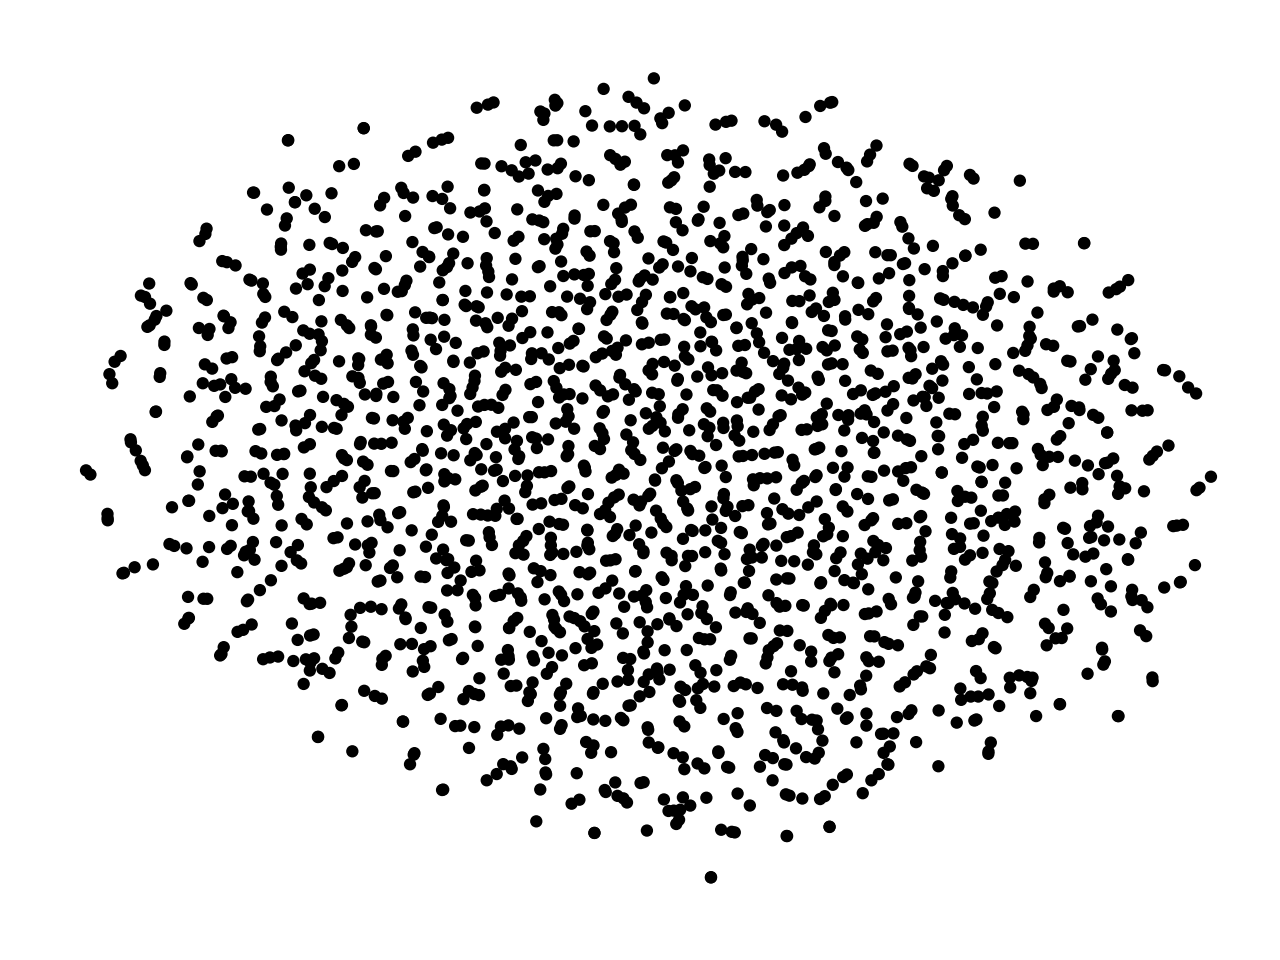

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(tsne_plot_data, mapping=aes(x='x', y='y'))+
 geom_point()+
 theme_void())

# **Part 3: Testing the Model**

# Getting Reuters Data Ready

Getting the Reuters data ready is very similar to getting the IMDB data ready. I am following the same process, just with the Reuters model and the Reuters data. I am training the Reuters model with the weights from the IMDB model to see how well the model is able to generalize across datasets.

In [ ]:
model_reuters = model_imdb

In [ ]:
def read_article(matched, missed):

    matches = []
    misses = []
    history = []

    for i in Reuters_padded:

        review_reward = 0

        fragments = []

        for j in np.arange(len(Reuters_padded[i])):
            for k in np.arange(1, len(Reuters_padded[i][j])-window_size, window_size):
                fragments.append(Reuters_padded[i][j][k:(k+window_size)])
        fragments = np.array(fragments)

        target_word = fragments[:,(window_size-1)]

        given_words = fragments[:,0:(window_size-1)]

        history = []

    for a in range(len(given_words)):
        chosen_word = guess_word(model_reuters, given_words[a])

        history.append((given_words[a], chosen_word))

        if chosen_word == target_word[a]:
            reward = 1
        else:
            reward = -1

        if reward > 0:
            matches.append(history[-1])
        if reward < 0:
            misses.append(history[-1])

        review_reward += reward

    return review_reward, matches, misses

def guess_word(model_reuters, given_words):
        word_probability = model_reuters(given_words)
        chosen_word = np.random.binomial(1, word_probability)
        return chosen_word[0]

In [ ]:
def iterate_reuters(rounds):
    matches = []
    misses = []

    for i in range(rounds):
        reward, matched, missed = read_review(Reuters_padded, model_reuters)
        matches += matched
        misses += missed
        print(f"Iteration {i + 1} of {rounds}. Reward {reward}.")

    return matches, misses

In [ ]:
def train_model_reuters(matches, misses):

    states = np.array([word[0] for word in misses] + [word[0] for word in matches])
    actions = np.array([1-word[1] for word in misses] + [word[1] for word in matches])

    model_reuters.fit(states, actions, batch_size=24, epochs=1)

In [ ]:
episodes = 1

iterations_per_episode = 1

for episode in np.arange(episodes):
    matches = []
    misses = []

    for i in np.arange(iterations_per_episode):
        matched, missed = iterate_imdb(rounds=1)

        matches = matches + matched
        misses = misses + missed

Iteration 1 of 1. Reward 0.


# Getting the Reuters Embeddings

To get these embeddings, I followed the same procedure as with the IMDB data.

The graph of the two-dimensional embedding vectors from the Reuters data is similar to the graph for the IMDB data, although there are some differences in clustering. This could suggest that the model was able to generalize between datasets. However, the embeddign vectors are likely to be variable with so few epochs of testing.

In [ ]:
reuters_embeddings = tf.keras.Model(inputs=input_1, outputs=embedding_1)

In [ ]:
reuters_embedding_vectors = reuters_embeddings.predict(np.arange(10000))

313/313 [==============================] - 0s 1ms/step


In [ ]:
two_dim_embeddings_reuters = tsne.fit_transform(reuters_embedding_vectors[:2000])
tsne_plot_data_reuters = pd.DataFrame(two_dim_embeddings_reuters, columns=["x", "y"])
tsne_plot_data_reuters['word'] = [inverted_word_lookup[i] for i in np.arange(2000)]

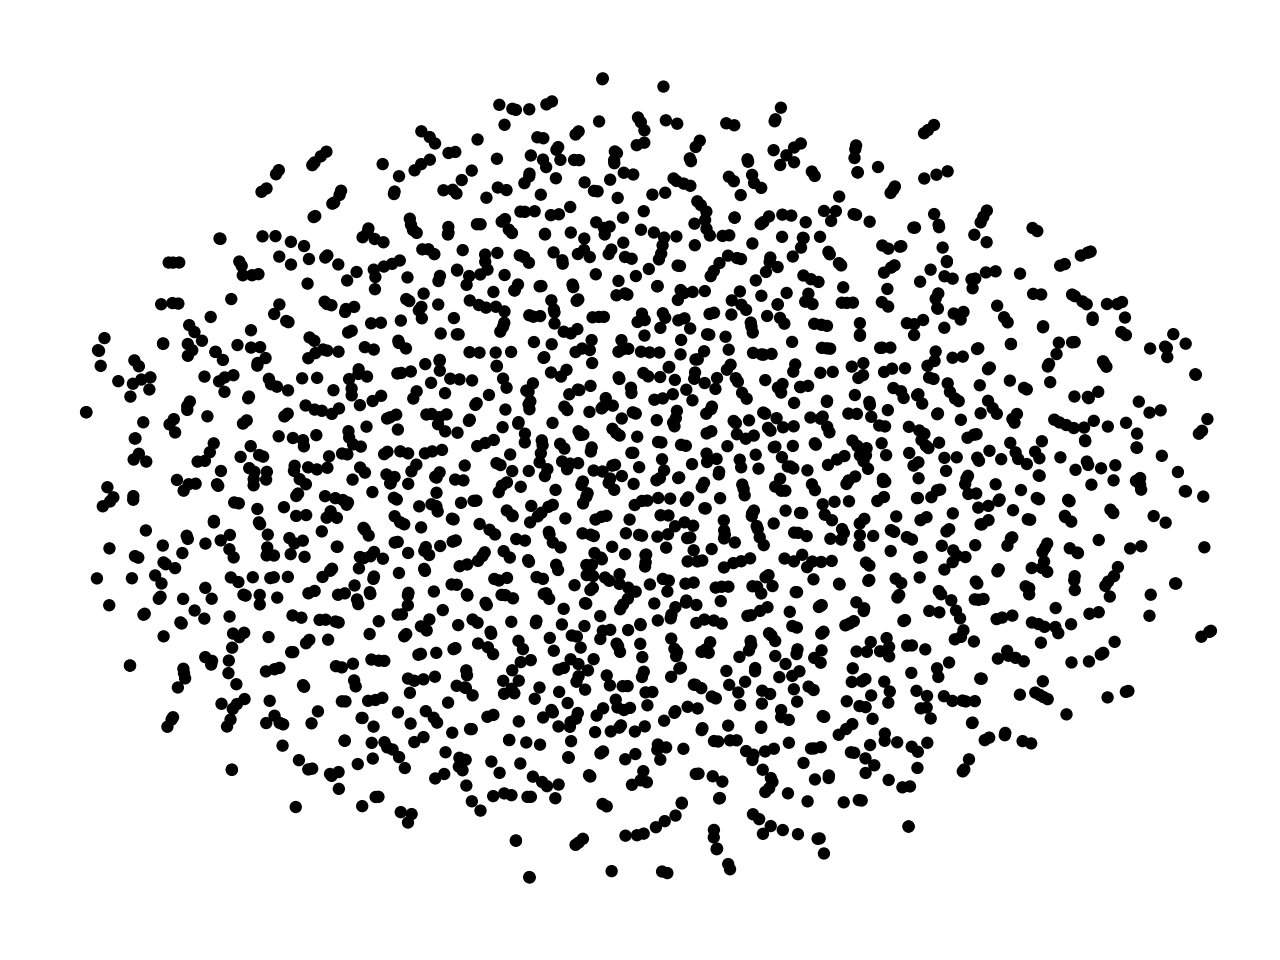

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(tsne_plot_data_reuters, mapping=aes(x='x', y='y'))+
 geom_point()+
 theme_void())

# **Conclusion**

I did this lab to see how reinforcement learning performed in next word prediction compared to the supervised learning that we have previously done. The second part of Lab 8 consisted of next word prediction with supervised learning. Compared to this, reinforcement learning performed relatively poorly, as the graphs of the two-dimensional embeddings showed less clusetering. One thing to note, though, is that reinforcement learning will alomst certainly require many more epochs of training before it begins to show any significant improvement.